> Gradient Inversion Attacks to Federated Learning: Harvard CS 2420 Computing at Scale (Fall 2024)


---

### **Breaking Privacy in Federated Learning**

In this project, I explored gradient inversion attacks which may break privacy in federated learning. In federated learning, each client receives the current global weights of the network and sends weights updates (gradients) based on local data. But how secure is sharing weights gradients? The [Deep Leakage](https://arxiv.org/pdf/1906.08935.pdf) paper shows it is possible to recover data given weights gradients.
To perform the attack, Deep Leakage first randomly generates a pair of "dummy" inputs and labels and then performs the usual forward and backwards computation.
After deriving the dummy gradients from the dummy data, instead of optimizing model weights as in typical training, Deep Leakage optimizes the dummy inputs and labels to minimize the distance between dummy gradients and real gradients. Feel free to refer to the paper for more details!

In [3]:
import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Running on cuda
GT label is 84. 
Onehot label is 84.
Dummy label is 85.
0 11.7605
10 0.1838
20 0.0400
30 0.0137
40 0.0049
50 0.0017
60 0.0006
70 0.0002
80 0.0001
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000
299 0.0000


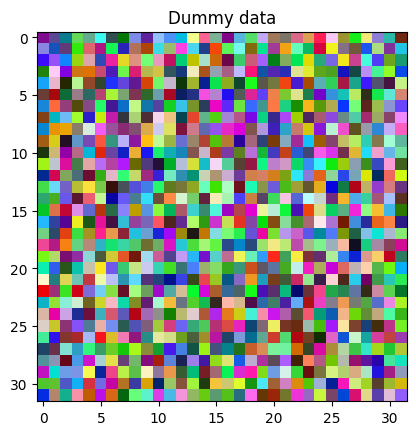

In [4]:
dst = torchvision.datasets.CIFAR100("./data", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))


def defense_method(dy_dx, defense_strategy):
  if defense_strategy=='none':
    return dy_dx

  elif defense_strategy=='pruning':
    # pruning

    for i in range(len(dy_dx)):
        num_prune = int(0.2 * dy_dx[i].numel() + 0.5)

        original_shape = dy_dx[i].shape
        flattened = torch.abs(dy_dx[i].flatten())

        _, indices = torch.topk(flattened, num_prune, largest = False)
        flattened[indices] = 0

        dy_dx[i] = flattened.view(original_shape)
    return dy_dx

  elif defense_strategy=='quantization':
    # quantization

    for i in range(len(dy_dx)):
        dy_dx[i] = dorefa_g(dy_dx[i], 4)[0]
    return dy_dx

  elif defense_strategy=='noise':
    # noise injection

    for i in range(len(dy_dx)):
        noise = torch.normal(mean=0, std=0.001, size=dy_dx[i].shape, device=dy_dx[i].device)
        dy_dx[i] += noise
    return dy_dx

  return None

original_dy_dx = defense_method(original_dy_dx, 'none')

######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)

    ## Also print for the last iteration
    if iters % 10 == 0 or iters == 299:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 84.


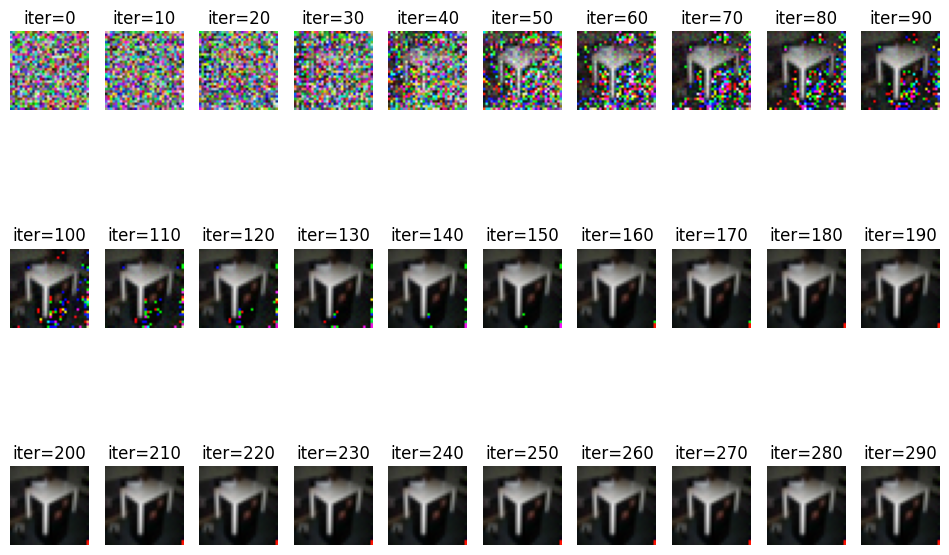

In [5]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')

  ## Save the figure
  plt.savefig('none.png', dpi=250)
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Files already downloaded and verified
Running on cuda
none | Iter: 0 | Loss: 37.6830
none | Iter: 10 | Loss: 1.0529
none | Iter: 20 | Loss: 0.1714
none | Iter: 30 | Loss: 0.0387
none | Iter: 40 | Loss: 0.0096
none | Iter: 50 | Loss: 0.0029
none | Iter: 60 | Loss: 0.0010
none | Iter: 70 | Loss: 0.0003
none | Iter: 80 | Loss: 0.0001
none | Iter: 90 | Loss: 0.0000
none | Iter: 100 | Loss: 0.0000
none | Iter: 110 | Loss: 0.0000
none | Iter: 120 | Loss: 0.0000
none | Iter: 130 | Loss: 0.0000
none | Iter: 140 | Loss: 0.0000
none | Iter: 150 | Loss: 0.0000
none | Iter: 160 | Loss: 0.0000
none | Iter: 170 | Loss: 0.0000
none | Iter: 180 | Loss: 0.0000
none | Iter: 190 | Loss: 0.0000
none | Iter: 200 | Loss: 0.0000
none | Iter: 210 | Loss: 0.0000
none | Iter: 220 | Loss: 0.0000
none | Iter: 230 | Loss: 0.0000
none | Iter: 240 | Loss: 0.0000
none | Iter: 250 | Loss: 0.0000
none | Iter: 260 | Loss: 0.0000
none | Iter: 270 | Loss: 0.0000
none | Iter: 280 | Loss: 0.0000
none | Iter: 290 | Loss: 0.0

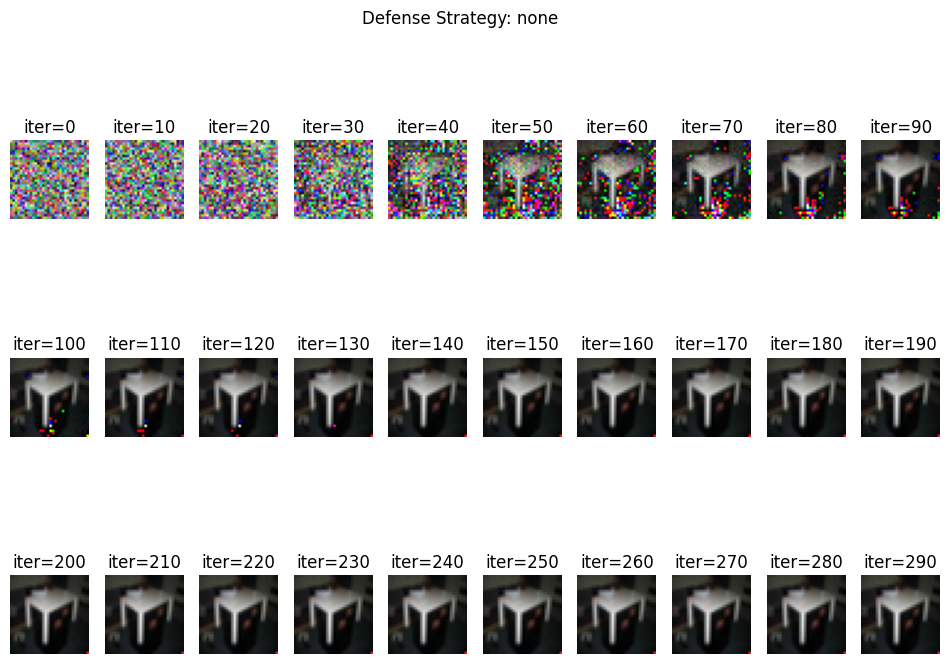

Dummy label is 84 for defense: none
pruning | Iter: 0 | Loss: 457.2714
pruning | Iter: 10 | Loss: 431.9457
pruning | Iter: 20 | Loss: 429.8718
pruning | Iter: 30 | Loss: 429.2493
pruning | Iter: 40 | Loss: 428.9914
pruning | Iter: 50 | Loss: 428.7681
pruning | Iter: 60 | Loss: 428.5969
pruning | Iter: 70 | Loss: 428.4672
pruning | Iter: 80 | Loss: 428.3684
pruning | Iter: 90 | Loss: 428.3133
pruning | Iter: 100 | Loss: 428.2701
pruning | Iter: 110 | Loss: 428.2332
pruning | Iter: 120 | Loss: 428.1932
pruning | Iter: 130 | Loss: 428.1624
pruning | Iter: 140 | Loss: 428.1358
pruning | Iter: 150 | Loss: 428.1071
pruning | Iter: 160 | Loss: 428.0890
pruning | Iter: 170 | Loss: 428.0748
pruning | Iter: 180 | Loss: 428.0539
pruning | Iter: 190 | Loss: 428.0329
pruning | Iter: 200 | Loss: 428.0195
pruning | Iter: 210 | Loss: 428.0081
pruning | Iter: 220 | Loss: 428.0008
pruning | Iter: 230 | Loss: 427.9891
pruning | Iter: 240 | Loss: 427.9826
pruning | Iter: 250 | Loss: 427.9751
pruning | Ite

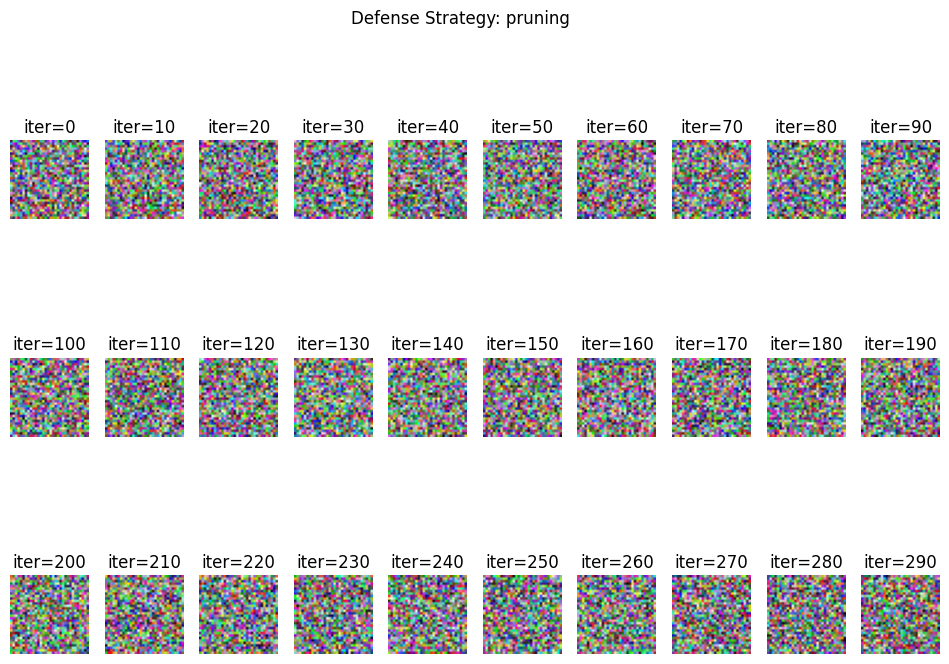

Dummy label is 19 for defense: pruning
quantization | Iter: 0 | Loss: 462.8566
quantization | Iter: 10 | Loss: 433.9897
quantization | Iter: 20 | Loss: 432.8122
quantization | Iter: 30 | Loss: 432.4453
quantization | Iter: 40 | Loss: 432.2453
quantization | Iter: 50 | Loss: 432.1127
quantization | Iter: 60 | Loss: 432.0094
quantization | Iter: 70 | Loss: 431.9393
quantization | Iter: 80 | Loss: 431.8869
quantization | Iter: 90 | Loss: 431.8475
quantization | Iter: 100 | Loss: 431.8098
quantization | Iter: 110 | Loss: 431.7685
quantization | Iter: 120 | Loss: 431.7440
quantization | Iter: 130 | Loss: 431.7242
quantization | Iter: 140 | Loss: 431.7106
quantization | Iter: 150 | Loss: 431.6964
quantization | Iter: 160 | Loss: 431.6714
quantization | Iter: 170 | Loss: 431.6562
quantization | Iter: 180 | Loss: 431.6391
quantization | Iter: 190 | Loss: 431.6267
quantization | Iter: 200 | Loss: 431.6091
quantization | Iter: 210 | Loss: 431.5957
quantization | Iter: 220 | Loss: 431.5909
quanti

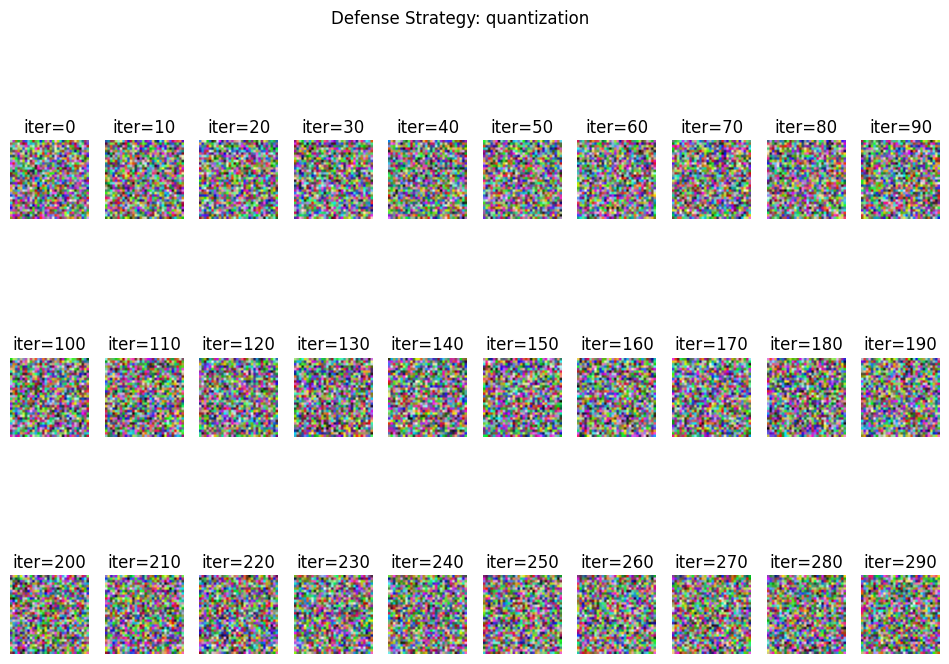

Dummy label is 19 for defense: quantization
noise | Iter: 0 | Loss: 463.4710
noise | Iter: 10 | Loss: 433.3400
noise | Iter: 20 | Loss: 432.3962
noise | Iter: 30 | Loss: 431.8207
noise | Iter: 40 | Loss: 431.3188
noise | Iter: 50 | Loss: 431.1251
noise | Iter: 60 | Loss: 430.9807
noise | Iter: 70 | Loss: 430.8709
noise | Iter: 80 | Loss: 430.7892
noise | Iter: 90 | Loss: 430.6681
noise | Iter: 100 | Loss: 430.5343
noise | Iter: 110 | Loss: 430.4519
noise | Iter: 120 | Loss: 430.3535
noise | Iter: 130 | Loss: 430.2742
noise | Iter: 140 | Loss: 430.2103
noise | Iter: 150 | Loss: 430.1484
noise | Iter: 160 | Loss: 430.1006
noise | Iter: 170 | Loss: 430.0642
noise | Iter: 180 | Loss: 430.0360
noise | Iter: 190 | Loss: 430.0080
noise | Iter: 200 | Loss: 429.9805
noise | Iter: 210 | Loss: 429.9624
noise | Iter: 220 | Loss: 429.9485
noise | Iter: 230 | Loss: 429.9372
noise | Iter: 240 | Loss: 429.9275
noise | Iter: 250 | Loss: 429.9198
noise | Iter: 260 | Loss: 429.9009
noise | Iter: 270 | Lo

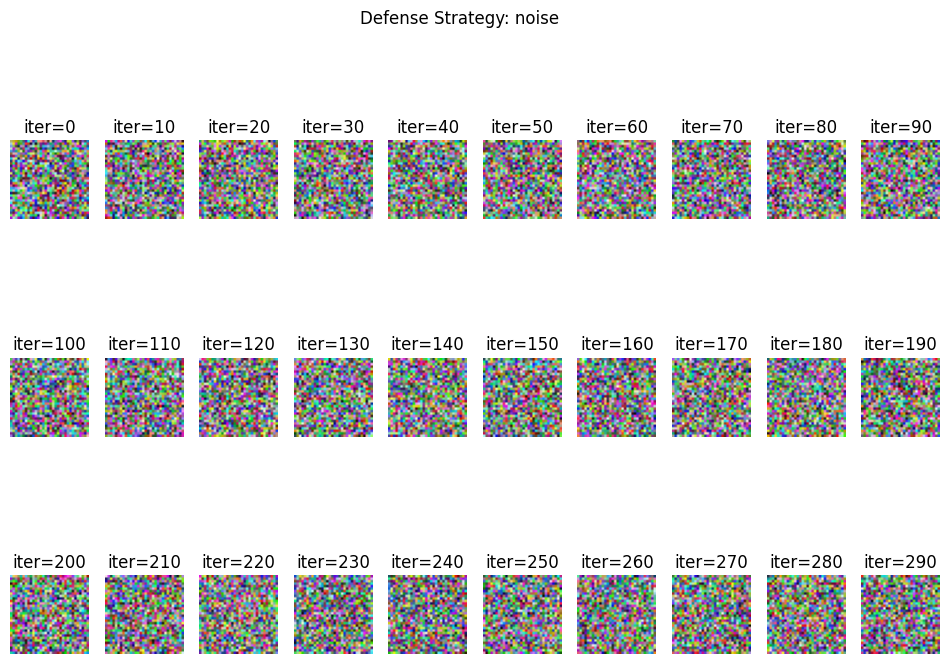

Dummy label is 19 for defense: noise


In [12]:
# Load CIFAR100 dataset
dst = torchvision.datasets.CIFAR100("./data", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

# Define LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Load sample image and label
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# Compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# Define defense methods
def defense_method(dy_dx, defense_strategy):
    if defense_strategy == 'none':
        return dy_dx
    elif defense_strategy == 'pruning':
        for i in range(len(dy_dx)):
            num_prune = int(0.2 * dy_dx[i].numel() + 0.5)
            original_shape = dy_dx[i].shape
            flattened = torch.abs(dy_dx[i].flatten())
            _, indices = torch.topk(flattened, num_prune, largest=False)
            flattened[indices] = 0
            dy_dx[i] = flattened.view(original_shape)
        return dy_dx
    elif defense_strategy == 'quantization':
        for i in range(len(dy_dx)):
            dy_dx[i] = torch.round(dy_dx[i] * 15) / 15  # Simulate quantization to 4-bit
        return dy_dx
    elif defense_strategy == 'noise':
        for i in range(len(dy_dx)):
            noise = torch.normal(mean=0, std=0.001, size=dy_dx[i].shape, device=dy_dx[i].device)
            dy_dx[i] += noise
        return dy_dx
    return None

# Defense strategies to test
defense_strategies = ['none', 'pruning', 'quantization', 'noise']

# Loop through each defense strategy
for defense in defense_strategies:
    # Apply defense
    defended_dy_dx = defense_method(original_dy_dx, defense)

    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    # Optimizer for dummy data and label
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    # History to store intermediate images
    history = []

    for iters in range(300):
        def closure():
            optimizer.zero_grad()
            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            # Calculate gradient difference
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, defended_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)

        if iters % 10 == 0 or iters == 299:
            current_loss = closure()
            print(f"{defense} | Iter: {iters} | Loss: {current_loss.item():.4f}")

        history.append(tt(dummy_data[0].cpu()))

    # Plot each defense's history in a separate figure
    plt.figure(figsize=(12, 8))
    for i in range(30):
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[i * 10])
        plt.title(f"iter={i * 10}")
        plt.axis('off')

    # Save the figure for each defense strategy
    plt.savefig(f'{defense}.png', dpi=250)
    plt.suptitle(f"Defense Strategy: {defense}")
    plt.show()
    print(f"Dummy label is {torch.argmax(dummy_label, dim=-1).item()} for defense: {defense}")